<a href="https://colab.research.google.com/github/liquidx/ml/blob/main/Mobile_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A notebook to practice building a GAN for mobile screenshots based on:

* [ncoop57/rico_captions](https://huggingface.co/datasets/ncoop57/rico_captions)
* https://youtu.be/AALBGpLbj6Q
* https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

To read:
* https://www.tensorflow.org/tutorials/generative/dcgan


Saving & Loading Checkpoints
* https://machinelearningmastery.com/check-point-deep-learning-models-keras/
* https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb



## 1 Dependencies

In [56]:
!pip -q install datasets transformers pillow rich 

In [57]:
import os
import numpy as np
import PIL
import PIL.Image
import pathlib
import pickle 
import time

from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

from datasets import load_dataset
from datasets import Image
from rich import inspect
from transformers import DataCollatorWithPadding


In [58]:
# Dependencies for Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model

# For subclassing
from tensorflow.keras.models import Model
# For ModelMonitor Callback
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


In [59]:
HAS_COLAB = False
try:
  import google.colab
  HAS_COLAB = True
except ImportError:
  pass


In [60]:
CHECKPOINTS_DIR = './checkpoints'
if HAS_COLAB:
  google.colab.drive.mount('/content/drive')
  CHECKPOINTS_DIR = '/content/drive/MyDrive/ML/checkpoints/mobilegan'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2 Initialize

In [61]:
# Bringing in tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
gpus    

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [62]:

seed = 123
image_size = (64, 32)
channels = 3
latent_vector_z = 100

batch_size = 128
buffer_size = 50000
prefetch_size = 64

LATENT_DIM = 128


## 3 Load Dataset

In [63]:
rico_dataset = load_dataset("ncoop57/rico_captions", split="train")

# Convert to TensorFlow compat data set
# rico_dataset_tf = rico_dataset.to_tf_dataset(columns=['screenshot_path'], batch_size=batch_size, shuffle=True)

# Load images and normalize using HF Datasets
# This is hugely inefficient since it tries to load them all rather than only
# when we use them.
# def hfd_load_image_and_normalize(row):
#   img = tf.keras.utils.load_img(row['screenshot_path'], 
#                                 grayscale=False, 
#                                 color_mode='rgb', 
#                                 target_size=image_size)
#   data = tf.keras.preprocessing.image.img_to_array(img)
#   row['image'] = data / 255.0
#   return row

# rico_dataset = rico_dataset.map(hfd_load_image_and_normalize)


In [64]:
# Loading using standard keras utils

def scale_images(image):
  """Normalize RGB values to 0-1"""
  return image / 255.0


def load_using_keras_dataset(dirname):
  """
  This will already do batching/shuffling/prefetch
  https://github.com/keras-team/keras/blob/v2.9.0/keras/utils/image_dataset.py#L29-L235
  """
  ds = image_dataset_from_directory(dirname, 
                                    labels=None,
                                    color_mode="rgb",
                                    shuffle=True,
                                    image_size=image_size,
                                    batch_size=batch_size)
  return ds.map(scale_images)
  
#
# Functions for loading manually from the paths.
#

def load_image_and_normalize(path):
  print(path.eval())
  img = tf.keras.utils.load_img(path, grayscale=False, color_mode='rgb', target_size=image_size)
  data = tf.keras.preprocessing.image.img_to_array(img)
  return data / 255.0

def load_manually(dataset):
  ds = dataset
  ds = ds.map(load_image_and_normalize)
  # The dataset is already batched and shuffled
  ds = ds.cache()
  ds = ds.shuffle(buffer_size)
  # Batches 128 images per sample
  ds = ds.batch(batch_size)
  # Reduces bottlenecking
  ds = ds.prefetch(prefetch_size)
  return ds


In [65]:
screenshot_dir = os.path.dirname(rico_dataset[0]["screenshot_path"])
ds = load_using_keras_dataset(screenshot_dir)
# ds = load_manually(rico_dataset)

Found 24598 files belonging to 1 classes.


In [66]:
ds.take(1).element_spec

TensorSpec(shape=(None, 64, 32, 3), dtype=tf.float32, name=None)

## 4 Inspect Dataset (optional)

(128, 64, 32, 3)


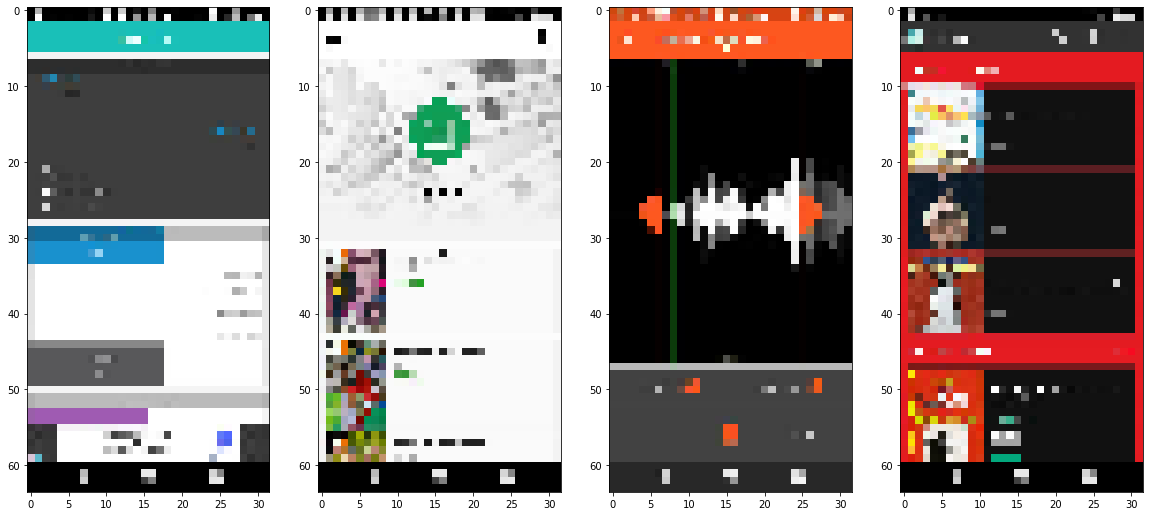

In [ ]:
# Quick wat to visualize
data_iterator = ds.as_numpy_iterator()
plot_count = 4
fig, ax = plt.subplots(ncols=plot_count, figsize=(20, 10))
# gets a batch (which will be batch size)
batch = data_iterator.next()
print(batch.shape)

for i in range(plot_count):
  ax[i].imshow(np.squeeze(batch[i]))


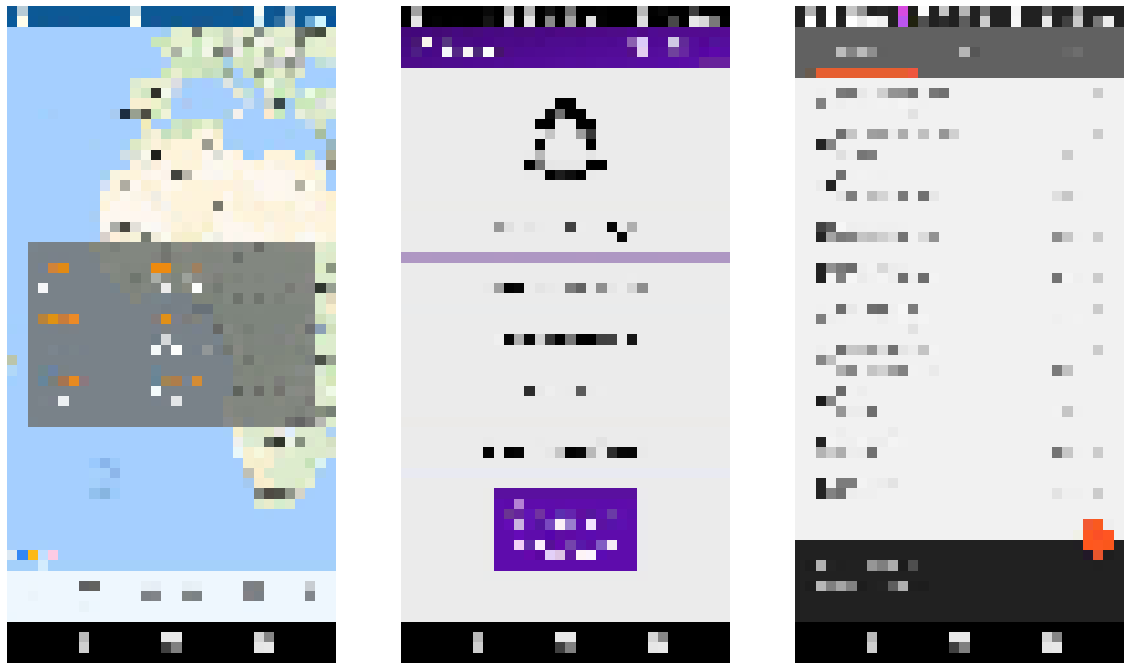

In [104]:
# Visualize what we've loaded
plt.figure(figsize=(20, 60))
for images in ds.take(1):  
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(images[i].numpy().astype("uint8"))
    plt.imshow(images[i].numpy())
    plt.axis("off")

## 5 Models

### 5.0 Common

In [67]:
def generate_latent_points(latent_dim, n_samples):
	"""Generate random points that will feed the generator."""
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [68]:
def generate_fake_samples(generator_model, latent_dim, img_count):
  """Generate some fake sample image data for the discriminator."""
  seed = generate_latent_points(latent_dim, img_count)
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  imgs = generator_model(seed, training=False)
  return imgs

In [109]:
def generate_and_show_subplots(g_model, latent_dim):
  img_count = 4
  imgs = generate_fake_samples(g_model, latent_dim, img_count)

  fig, ax = plt.subplots(ncols=img_count, figsize=(20, 10))
  for i, img in enumerate(imgs):
    ax[i].imshow(np.squeeze(img))

def generate_and_show(g_model, latent_dim, epoch=0, rows=2, cols=4, scale=8, output_dir=None):
  img_count = rows * cols
  imgs = generate_fake_samples(g_model, latent_dim, img_count)
  fig = plt.figure(figsize=(cols * scale, rows * scale * 2))

  for i in range(imgs.shape[0]):
    plt.subplot(rows, cols, i+1)
    plt.imshow(np.squeeze(imgs[i]))
    plt.axis('off')

  if output_dir:
    path = os.path.join(output_dir, 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.savefig()
    
  plt.show()


In [70]:
def checkpoint_models(g_model, d_model, g_opt, d_opt):
  return tf.train.Checkpoint(g_model=g_model,
                             d_model=d_model,
                             g_opt=g_opt,
                             d_opt=d_opt,)


In [71]:
class GANModelImageOutput(Callback):
  """Keras model callback for saving image snapshots during training."""
  def __init__(self, initial_epoch=0, num_images=3, latent_dim=128, checkpoints_dir="checkpoints"):
    self.initial_epoch = initial_epoch
    self.num_images = num_images
    self.latent_dim = latent_dim
    self.checkpoints_dir = checkpoints_dir

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_images, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    logical_epoch = epoch + 1
    
    for i in range(self.num_images):
      img = array_to_img(generated_images[i])
      img.save(os.path.join(self.checkpoints_dir, f'sample_{logical_epoch:02d}_{i}.png'))

In [72]:
class GANModelCheckpoint(Callback):
  """ Custom implementation of a checkpointer since the GAN model is a custom model."""

  training_state_filename = 'training-state.pkl'

  def __init__(self, initial_epoch=0, epoch_interval=1, checkpoints_dir='checkpoints'):
    self.last_epoch_saved = initial_epoch
    self.epoch_interval = epoch_interval
    self.checkpoints_dir = checkpoints_dir
    self.checkpoint_prefix = os.path.join(self.checkpoints_dir, 'checkpoint')


  def save_model_weights(self, epoch):
    g_model = self.model.generator
    d_model = self.model.discriminator
    g_opt = self.model.g_opt
    d_opt = self.model.d_opt

    checkpoint = checkpoint_models(g_model, d_model, g_opt, d_opt)
    output_path = checkpoint.save(file_prefix = self.checkpoint_prefix)
    return output_path


  def on_epoch_end(self, epoch, logs=None):
    print()
    print(f'Epoch ended: {epoch} (last saved: {self.last_epoch_saved}, interval: {self.epoch_interval})')
    should_save = False
    completed_epochs = epoch + 1
    if completed_epochs - self.last_epoch_saved >= self.epoch_interval:
      should_save = True

    if should_save:
      print('Saving state...')
      self.save_model_weights(epoch)
      self.last_epoch_saved = completed_epochs

  def on_train_end(self, logs=None):
    self.save_model_weights(self.params['epochs'])

In [73]:
def save_training_history(history, history_path):
  with open(history_path, 'wb') as f:
    pickle.dump(history, f)
  return history

def load_training_history(history_path):
  if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
      return pickle.load(f)
  else:
    return []

class GANModelTrainingHistory(Callback):
  def __init__(self, output_path=None):
    self.output_path = output_path
    self.history = load_training_history(output_path)

  def on_epoch_end(self, current_epoch, logs=None):
    if logs:
      completed_epochs = current_epoch + 1
      print(logs)
      history.append({"epoch": current_epoch})
      save_training_history(self.history, self.output_path)

  

### 5.1 Renotte: Upsample/Convulution + Back Prop


In [ ]:
def build_generator_v1(latent_dim):
  """
  Generator from https://youtu.be/AALBGpLbj6Q

  """
  model = Sequential()

  # First hidden layer has enough nodes to represent a low
  # rest version of the output image.
  n = 256 
  n_nodes = n * 8 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((8, 4, n)))

  # Upsampling Block 1
  # Upsampling the lower res to a higher res (deconvolution)
  model.add(UpSampling2D())
  model.add(Conv2D(n, 5, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Upsampling Block 2
  model.add(UpSampling2D())
  model.add(Conv2D(n, 5, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

 # Upsampling Block 3
  model.add(UpSampling2D())
  model.add(Conv2D(n, 4, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Convolution block 1
  # Only in Nicholas' tutorial
  model.add(Conv2D(n, 4, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Convolution block 2
  # Only in Nicholas' tutorial
  model.add(Conv2D(n, 4, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))
  return model


In [ ]:
def build_discriminator_v1(in_shape=(64, 32, 3)):
  model = Sequential()

  # Normal
  model.add(Conv2D(64, 5, input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4)) 

  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))


  model.add(Conv2D(256, 8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dropout(0.4)) 
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
class MobileGAN(Model):
  """A wrapper model for running the training steps."""
  def __init__(self, generator, discriminator, latent_dim, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator
    self.latent_dim = latent_dim

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def compile_submodels(self):
    """Further compile the submodels manually."""
    # Because the generator is not trained, we don't need to compile it.  
    #self.generator.compile(loss=self.g_loss, optimizer=self.g_opt, metrics=['accuracy'])
    self.discriminator.compile(loss=self.d_loss, optimizer=self.d_opt, metrics=['accuracy'])


  # https://www.tensorflow.org/tutorials/generative/dcgan#define_the_training_loop
  def train_step(self, batch):
    # Get the data
    real_images = batch
    # TODO: use the common function generate_fake_data?
    fake_images = self.generator(tf.random.normal((batch_size, self.latent_dim, 1)), training=False)

    # Training : Discriminator
    with tf.GradientTape() as d_tape:
      # Pass the real and fake images to the discriminator
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # Create labels for the real and fake
      # 0 = real
      # 1 = fake
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      # Add noise to the outputs.
      # Add a bit of confusion in to the discriminator to avoid it being
      # too good.
      # -0.15 is from trial and error
      noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))

      y_realfake += tf.concat([noise_real, noise_fake], axis=0)
                               
      # Calculate loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    # Apply backpropagation
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))


    # Training : Generator
    with tf.GradientTape() as g_tape:
      # Generate some new images
      gen_images = self.generator(tf.random.uniform((batch_size, self.latent_dim, 1)),training=True)
      # Generate our predicted labels
      predicted_labels = self.discriminator(gen_images, training=False)
      # Tell the generator that we are right if the discriminator is "wrong",
      # thinks that our images are real (label = 0)
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
    return {"d_loss":total_d_loss, "g_loss":total_g_loss}
    

In [ ]:
def create_gan_model_v1(latent_dim, g_opt_learning_rate=0.0001, d_opt_learning_rate=0.00001):
  generator = build_generator_v2(latent_dim)
  discriminator = build_discriminator_v2()

  mobilegan = MobileGAN(generator, discriminator, latent_dim)

  # Setup the losses and optimizers
  g_opt = Adam(learning_rate=g_opt_learning_rate,  beta_1=0.5)
  d_opt = Adam(learning_rate=d_opt_learning_rate,  beta_1=0.5)
  g_loss = BinaryCrossentropy()
  d_loss = BinaryCrossentropy()

  mobilegan.compile(g_opt, d_opt, g_loss, d_loss)

  return mobilegan

### 5.2 ML Mastery & TF DCGAN

Model and implementation primarily from [Machine Learning Mastery](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/) and [DCGAN Tutorial](https://www.tensorflow.org/tutorials/generative/dcgan)

In [74]:
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

def build_generator_v2(latent_dim):
  """
  The generator will go from 8x4 to 16x8 to 32x16 to 64x32.

  """
  model = Sequential()

  n = 256 
  n_nodes = n * 8 * 4

  # First hidden layer has enough nodes to represent a low
  # rest version of the output image.
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((8, 4, n)))

  # Upsample from 8x4 to 16x8
  model.add(Conv2DTranspose(n, (8, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Upsample from 16x8 to 32x16
  model.add(Conv2DTranspose(n, (8, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Upsample from 32x16 to 64x32
  model.add(Conv2DTranspose(n, (8, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))
  return model


In [75]:

def build_discriminator_v2(in_shape=(64, 32, 3)):
  model = Sequential()

  # Normal
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))

  # Downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # Classifier
  model.add(Flatten())
  model.add(Dropout(0.4)) 
  model.add(Dense(1, activation='sigmoid'))
  return model

In [76]:
def create_gan_model_v2(latent_dim, g_opt_learning_rate=0.0001, d_opt_learning_rate=0.00001):
  # generator is not compiled
  generator = build_generator_v2(latent_dim)

  discriminator = build_discriminator_v2()
  d_opt = Adam(learning_rate=d_opt_learning_rate,  beta_1=0.5)
  d_loss = BinaryCrossentropy()
  discriminator.compile(loss=d_loss, optimizer=d_opt, metrics=['accuracy'])
  discriminator.trainable = False

  gan_model = Sequential()
  gan_model.add(generator)
  gan_model.add(discriminator)
  g_opt = Adam(learning_rate=g_opt_learning_rate,  beta_1=0.5)
  g_loss = BinaryCrossentropy()
  gan_model.compile(loss=g_loss, optimizer=g_opt)

  return (gan_model, generator, discriminator, g_opt, d_opt)

## 8. Train

In [ ]:
!mkdir checkpoints

### 8.1 Train with Renotte method.

In [ ]:
# Create a checkpointer that we can use to resume if the training is terminated.
# Saves at every epoch
#
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

def load_weights(model, checkpoints_dir='checkpoints'):
  g_model_weights = f'generator-{GANModelCheckpoint.model_weights_suffix}'
  d_model_weights = f'discriminator-{GANModelCheckpoint.model_weights_suffix}'
  training_state_filename = GANModelCheckpoint.training_state_filename
  state = {'epoch': 0}

  training_state_path = os.path.join(checkpoints_dir, training_state_filename)
  if not os.path.exists(training_state_path):
    return state

  with open(training_state_path, 'rb') as f:
    state = pickle.load(f)
    print('Loading state', state)
    model.d_opt = Adam.from_config(state['d_opt'])
    model.g_opt = Adam.from_config(state['g_opt'])

  g_model_weights_path = os.path.join(checkpoints_dir, g_model_weights)
  if os.path.exists(g_model_weights_path):
    model.generator.load_weights(g_model_weights_path)

  d_model_weights_path = os.path.join(checkpoints_dir, d_model_weights)

  if os.path.exists(d_model_weights_path):
    model.discriminator.load_weights(d_model_weights_path)

  model.compile_submodels()

  return state


def resume_train_gan(model, 
                     initial_epoch=0, 
                     epochs=200, 
                     epochs_per_checkpoint=2, 
                     checkpoints_dir='checkpoints'):
  """Start or resume training the GAN."""
  callbacks = [
      GANModelImageOutput(initial_epoch=initial_epoch, 
                   checkpoints_dir=checkpoints_dir), 
      GANModelCheckpoint(initial_epoch=initial_epoch, 
                         epoch_interval=epochs_per_checkpoint, 
                         checkpoints_dir=checkpoints_dir),
      GANModelTrainingHistory(output_path=os.path.join(checkpoints_dir, 'training-history.pkl'))               
  ]
  hist = model.fit(ds, epochs=epochs, initial_epoch=initial_epoch, callbacks=callbacks)  
  return hist



def train_v1(checkpoints_dir="checkpoints"):
  d_opt_lr = 0.00002 # learning rates
  g_opt_lr = d_opt_lr * 100
  gan_model = create_gan_model_v1(LATENT_DIM, 
                                  g_opt_learning_rate=g_opt_lr, 
                                  d_opt_learning_rate=d_opt_lr)
  state = load_weights(gan_model, checkpoints_dir=checkpoints_dir)


  hist = resume_train_gan(gan_model, 
                          initial_epoch=state['epoch'], 
                          epochs=200, 
                          epochs_per_checkpoint=5,
                          checkpoints_dir=checkpoints_dir)
  return hist



In [ ]:
train_v1(checkpoints_dir=CHECKPOINTS_DIR)

Loading state {'d_opt': {'name': 'Adam', 'learning_rate': 2e-05, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'g_opt': {'name': 'Adam', 'learning_rate': 0.002, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'epoch': 45}
Epoch 46/200
193/193 [==============================] - ETA: 0s - d_loss: 0.2677 - g_loss: 2.5911
Epoch ended: 45 (last saved: 44, interval: 5)
193/193 [==============================] - 108s 526ms/step - d_loss: 0.2677 - g_loss: 2.5912
Epoch 47/200
193/193 [==============================] - ETA: 0s - d_loss: 0.2688 - g_loss: 2.5861
Epoch ended: 46 (last saved: 44, interval: 5)
193/193 [==============================] - 98s 490ms/step - d_loss: 0.2688 - g_loss: 2.5861


KeyboardInterrupt: ignored

### 8.2 Train with TF & ML Mastery

In [ ]:
def train_gan_v2(gan_model, g_model, d_model, g_opt, d_opt,
                 dataset, latent_dim, 
                 epochs=200, 
                 initial_epoch=0, 
                 checkpoint_dir=None,
                 checkpoint_interval=10,
                 history_path=None):
  """
  In this GAN, y=0 real, y=1 fake.
  """
  history = []
  checkpoint = None
  checkpoint_prefix = None
  checkpoint_manager = None

  if checkpoint_dir:
    checkpoint = checkpoint_models(g_model, d_model, g_opt, d_opt)
    checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)
    checkpoint_manager.restore_or_initialize()

  if history_path:
    history = load_training_history(history_path)
    if len(history):
      latest_epoch = -1
      for hist in history:
        latest_epoch = max(hist['epoch'], latest_epoch)
      initial_epoch = latest_epoch + 1 # start from the next epoch

  print(f'Starting training from epoch {initial_epoch} until {epochs}')

  for epoch in range(initial_epoch, epochs):
    start = time.time()
    for batch in dataset.as_numpy_iterator():
      if batch.shape[0] < batch_size:
        continue # skip if it is not a full batch.
      real_images = batch
      fake_images = g_model(tf.random.normal((batch_size, latent_dim, 1)), training=False)
      X_real, y_real = (batch, np.zeros(batch_size))
      X_fake, y_fake = (fake_images, np.ones(batch_size))

      d_loss_real, _ = d_model.train_on_batch(X_real, y_real)
      d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)

      X_gan = generate_latent_points(latent_dim, batch_size)
      y_gan = np.zeros((batch_size, 1))

      g_loss = gan_model.train_on_batch(X_gan, y_gan)
    
    elapsed = time.time()-start
    if checkpoint:
      history.append({"epoch": epoch, 'd_loss_real': d_loss_real, 'd_loss_fake': d_loss_fake, 'g_loss': g_loss, 'elapsed': elapsed })
      if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_manager.save()
        save_training_history(history, history_path)

    display.clear_output(wait=True)
    generate_and_show(g_model, latent_dim, epoch=epoch)
    for hist in history:
      if "elapsed" not in hist:
        hist["elapsed"] = 0        
      print('Epoch: {epoch+ d_real={d_loss_real:.3f} d_fake={d_loss_fake:.3f} g_loss={g_loss:.3f} duration={elapsed:.1f}s'.format(**hist))
        

def train_v2(epochs=200, checkpoint_dir=None, checkpoint_interval=10, history_path=None):
  d_opt_lr = 0.000002 # learning rates
  g_opt_lr = d_opt_lr * 10
  gan_model, g_model, d_model, g_opt, d_opt = create_gan_model_v2(
      LATENT_DIM, 
      g_opt_learning_rate=g_opt_lr, 
      d_opt_learning_rate=d_opt_lr)  

  train_gan_v2(gan_model, g_model, d_model, g_opt, d_opt,
               ds, LATENT_DIM, 
               epochs=epochs,
               checkpoint_dir=checkpoint_dir,
               checkpoint_interval=checkpoint_interval,
               history_path=history_path)


Starting training from epoch 200 until 400
Epoch: 201 d_real=0.930 d_fake=0.638 g_loss=0.782 duration=154.6s
Epoch: 202 d_real=0.837 d_fake=0.620 g_loss=0.804 duration=141.9s
Epoch: 203 d_real=0.840 d_fake=0.677 g_loss=0.701 duration=128.4s


KeyboardInterrupt: ignored

In [112]:
model_version = '2.1'
current_checkpoints_dir = os.path.join(CHECKPOINTS_DIR, f'model-v{model_version}')
current_history_path = os.path.join(CHECKPOINTS_DIR, f'model-v{model_version}-history.pkl')

train_v2(epochs=400,
         checkpoint_dir=current_checkpoints_dir, 
         checkpoint_interval=5, 
         history_path=current_history_path)


### 8.3 Tensorflow Tutorial

https://www.tensorflow.org/tutorials/generative/dcgan

* This is slightly different from the tutorial where we make the discriminator output fake=1 and real=0 to match the other two tutorials

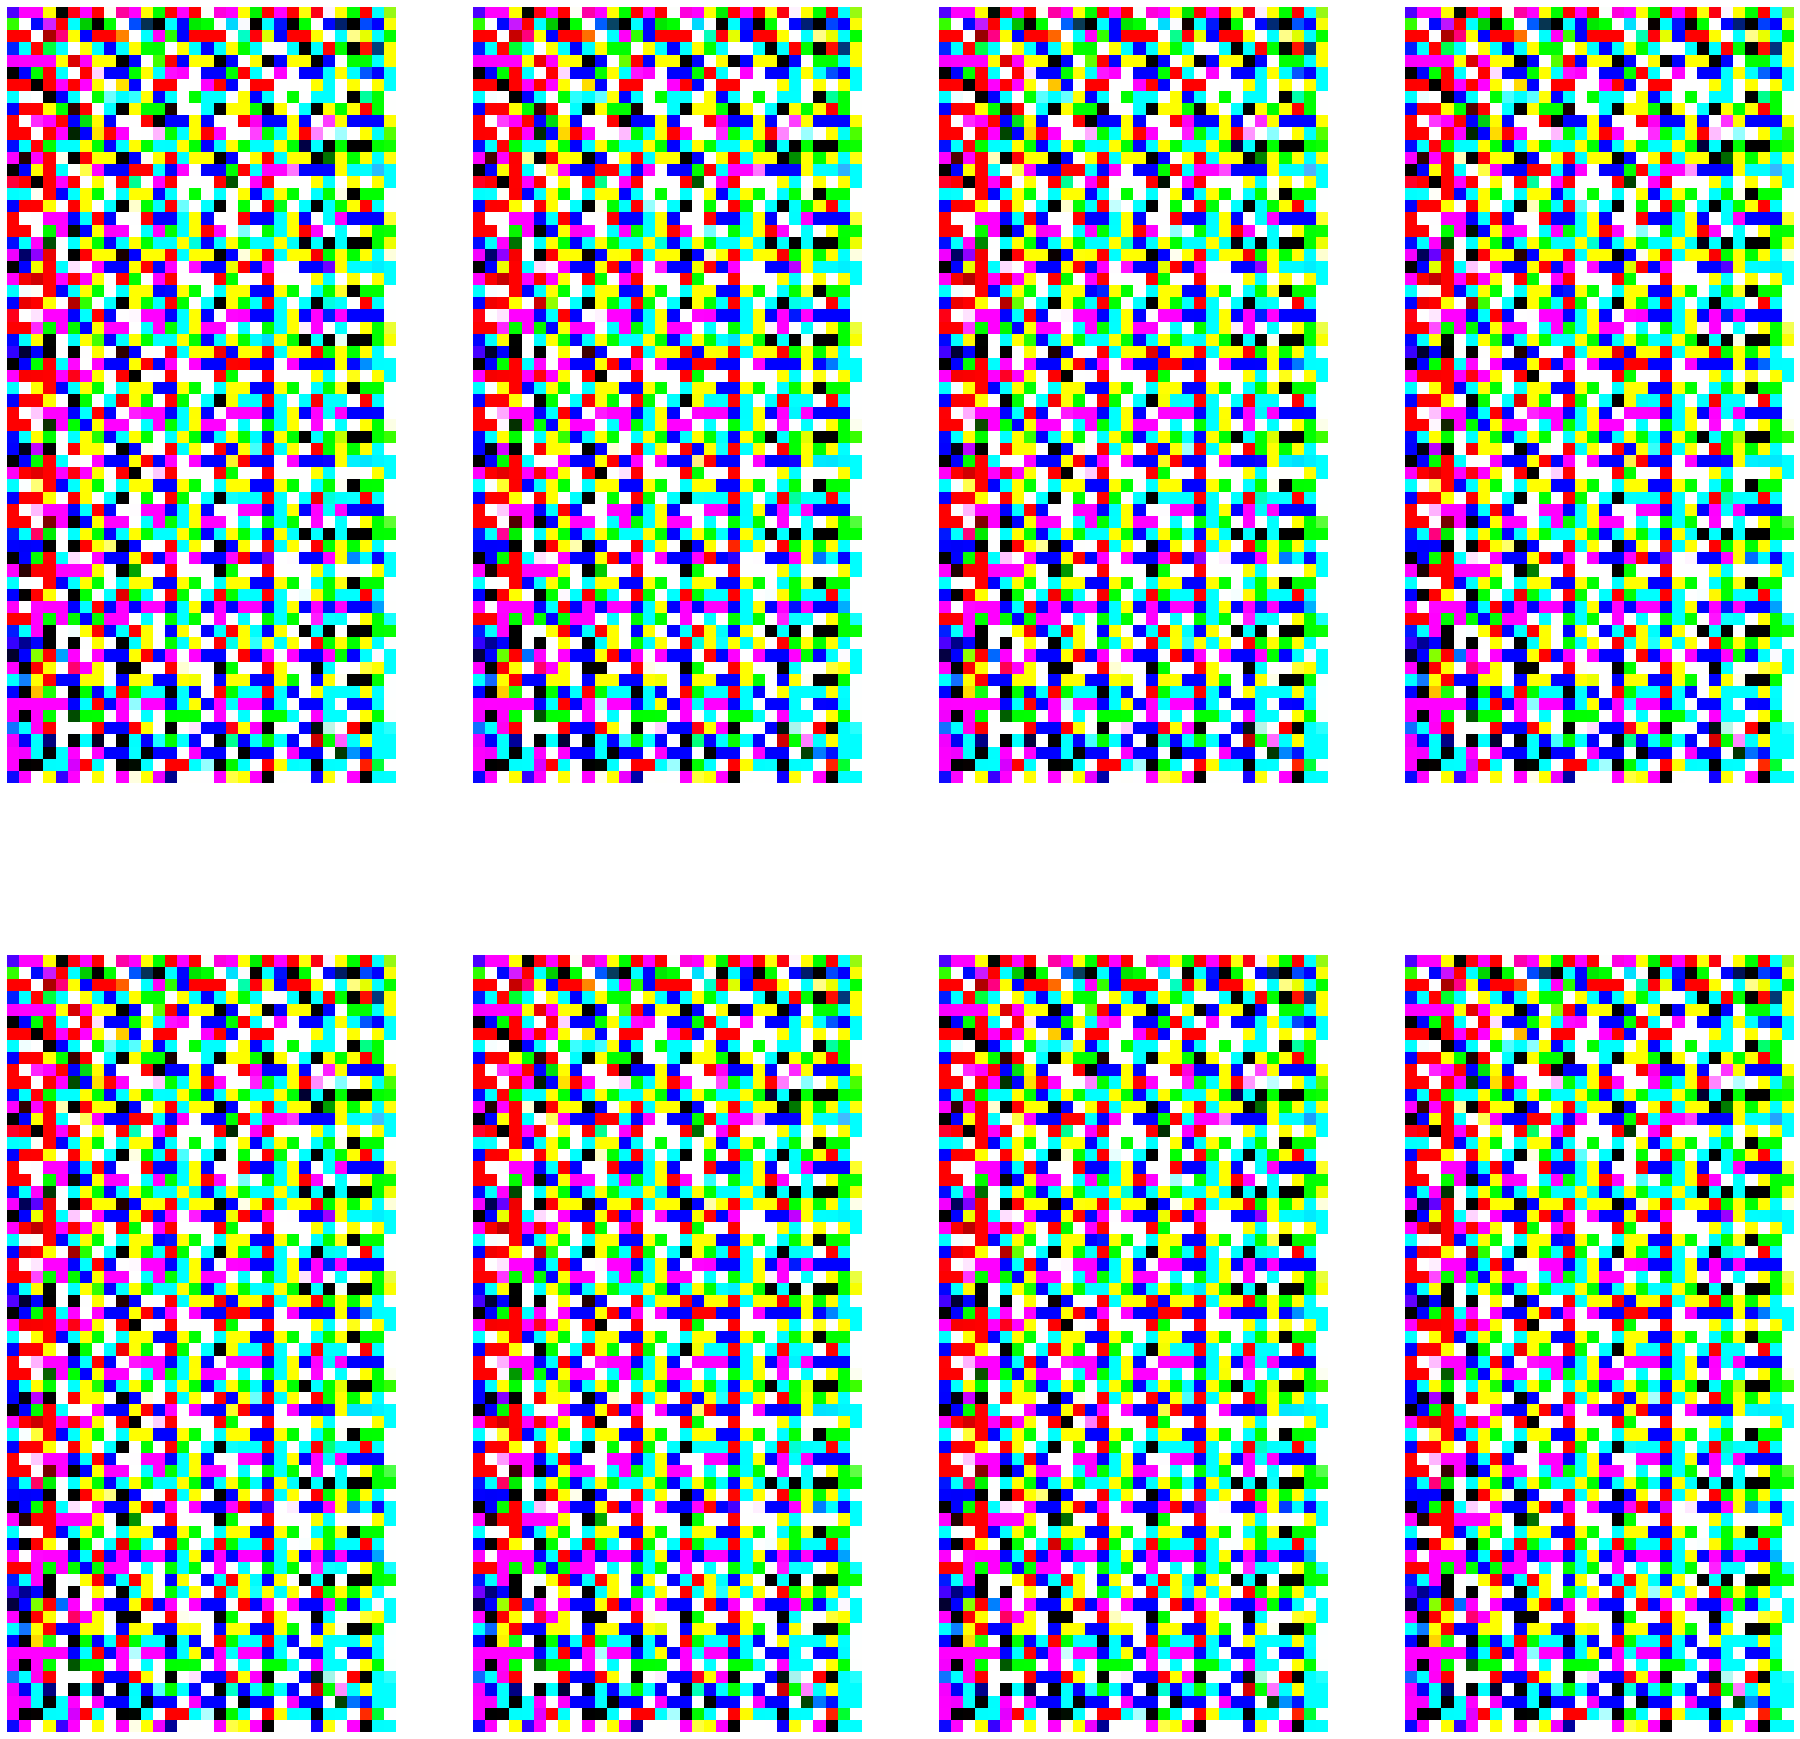

Epoch: 0 d_loss=1.619 g_loss=0.504 duration=0.0s
Epoch: 1 d_loss=1.703 g_loss=0.454 duration=0.0s
Epoch: 2 d_loss=1.739 g_loss=0.432 duration=0.0s
Epoch: 3 d_loss=1.759 g_loss=0.420 duration=0.0s
Epoch: 4 d_loss=1.780 g_loss=0.411 duration=0.0s
Epoch: 5 d_loss=1.789 g_loss=0.407 duration=0.0s
Epoch: 6 d_loss=1.800 g_loss=0.402 duration=0.0s
Epoch: 7 d_loss=1.805 g_loss=0.399 duration=0.0s
Epoch: 8 d_loss=1.809 g_loss=0.397 duration=0.0s
Epoch: 9 d_loss=1.810 g_loss=0.397 duration=0.0s
Epoch: 10 d_loss=1.808 g_loss=0.397 duration=98.8s
Epoch: 11 d_loss=1.813 g_loss=0.393 duration=93.4s
Epoch: 12 d_loss=1.818 g_loss=0.394 duration=141.9s
Epoch: 13 d_loss=1.816 g_loss=0.391 duration=96.6s
Epoch: 14 d_loss=1.821 g_loss=0.391 duration=141.9s
Epoch: 15 d_loss=1.817 g_loss=0.391 duration=99.4s
Epoch: 16 d_loss=1.825 g_loss=0.388 duration=141.9s
Epoch: 17 d_loss=1.827 g_loss=0.388 duration=141.9s


KeyboardInterrupt: ignored

In [119]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss_v3(real_output, fake_output):
    real_loss = cross_entropy(tf.zeros_like(real_output), real_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss_v3(fake_output):
    return cross_entropy(tf.zeros_like(fake_output), fake_output)

@tf.function
def train_gan_step_v3(gan_model, g_model, d_model, g_opt, d_opt, batch, latent_dim):
  real_images = batch
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    fake_images = g_model(tf.random.normal((batch_size, latent_dim, 1)), training=True)
    real_output = d_model(real_images, training=True)
    fake_output = d_model(fake_images, training=True)

    g_loss = generator_loss_v3(fake_output)
    d_loss = discriminator_loss_v3(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(g_loss, g_model.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(d_loss, d_model.trainable_variables)

  g_opt.apply_gradients(zip(gradients_of_generator, g_model.trainable_variables))
  d_opt.apply_gradients(zip(gradients_of_discriminator, d_model.trainable_variables))

  return (g_loss, d_loss)


def train_gan_v3(gan_model, g_model, d_model, g_opt, d_opt,
                 dataset, latent_dim, 
                 epochs=200, 
                 initial_epoch=0, 
                 checkpoint_dir=None,
                 checkpoint_interval=10,
                 history_path=None,
                 preview=True):

  history = []
  checkpoint = None
  checkpoint_prefix = None
  checkpoint_manager = None

  if checkpoint_dir:
    checkpoint = checkpoint_models(g_model, d_model, g_opt, d_opt)
    checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)
    checkpoint_manager.restore_or_initialize()

  if history_path:
    history = load_training_history(history_path)
    if len(history):
      latest_epoch = -1
      for hist in history:
        latest_epoch = max(hist['epoch'], latest_epoch)
      initial_epoch = latest_epoch + 1 # start from the next epoch

  print(f'Starting training from epoch {initial_epoch} until {epochs}')


  for epoch in range(initial_epoch, epochs):
    start = time.time()
    for batch in dataset.as_numpy_iterator():
      if batch.shape[0] < batch_size:
        continue # skip if it is not a full batch.
    
      g_loss, d_loss = train_gan_step_v3(gan_model, g_model, d_model, g_opt, d_opt, batch, latent_dim)

    elapsed = time.time() - start
    history.append({"epoch": epoch, 'd_loss': d_loss, 'g_loss': g_loss, 'elapsed': elapsed })

    if checkpoint:
      if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_manager.save()
        save_training_history(history, history_path)

    
    display.clear_output(wait=True)
    generate_and_show(g_model, latent_dim, epoch=epoch)
    for hist in history:
      if "elapsed" not in hist:
        hist["elapsed"] = 0
      print('Epoch: {epoch} d_loss={d_loss:.3f} g_loss={g_loss:.3f} duration={elapsed:.1f}s'.format(**hist))
        

def train_v3(epochs=200, checkpoint_dir=None, checkpoint_interval=10, history_path=None):
  d_opt_lr = 0.000002 # learning rates
  g_opt_lr = d_opt_lr * 10
  gan_model, g_model, d_model, g_opt, d_opt = create_gan_model_v2(
      LATENT_DIM, 
      g_opt_learning_rate=g_opt_lr, 
      d_opt_learning_rate=d_opt_lr)  

  train_gan_v3(gan_model, g_model, d_model, g_opt, d_opt,
               ds, LATENT_DIM, 
               epochs=epochs,
               checkpoint_dir=checkpoint_dir,
               checkpoint_interval=checkpoint_interval,
               history_path=history_path)



In [117]:
model_version = '3'
current_checkpoints_dir = os.path.join(CHECKPOINTS_DIR, f'model-v{model_version}')
current_history_path = os.path.join(CHECKPOINTS_DIR, f'model-v{model_version}-history.pkl')
train_v3(epochs=400,
         checkpoint_dir=current_checkpoint_dir, 
         checkpoint_interval=10, 
         history_path=current_history_path)

## Inspection

Performance inspection

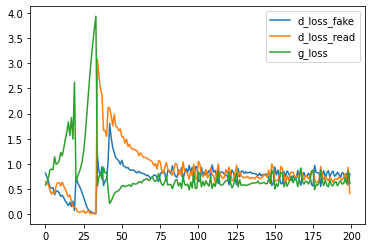

In [ ]:
def plot_losses_v2():
  hist = load_training_history(current_history_path)
  plt.plot([h['d_loss_fake'] for h in hist], label='d_loss_fake')
  plt.plot([h['d_loss_real'] for h in hist], label='d_loss_read')
  plt.plot([h['g_loss'] for h in hist], label='g_loss')
  plt.legend()
  plt.show()

plot_losses_v2()

[{'epoch': 0, 'd_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6188446>, 'g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.5039581>}, {'epoch': 1, 'd_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7034795>, 'g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.4538542>}, {'epoch': 2, 'd_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7387269>, 'g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.4324355>}, {'epoch': 3, 'd_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7587672>, 'g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.42007214>}, {'epoch': 4, 'd_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7804306>, 'g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.4112835>}, {'epoch': 5, 'd_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.7893102>, 'g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.40679958>}, {'epoch': 6, 'd_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.8002278>, 'g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.

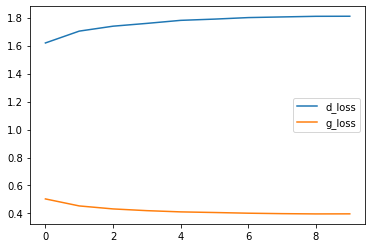

In [118]:
def plot_losses_v3():
  hist = load_training_history(current_history_path)
  print(hist)
  plt.plot([h['d_loss'] for h in hist], label='d_loss')
  plt.plot([h['g_loss'] for h in hist], label='g_loss')
  plt.legend()
  plt.show()

plot_losses_v3()

In [ ]:
def clear_history(dir):
  files = os.listdir(dir)
  for f in files:
    if f.endswith('hdf5'):
      print(f'Deleteing {f}')
      os.remove(os.path.join(dir, f))
    if f.endswith('pkl'):
      os.remove(os.path.join(dir, f))

# clear_history('.')

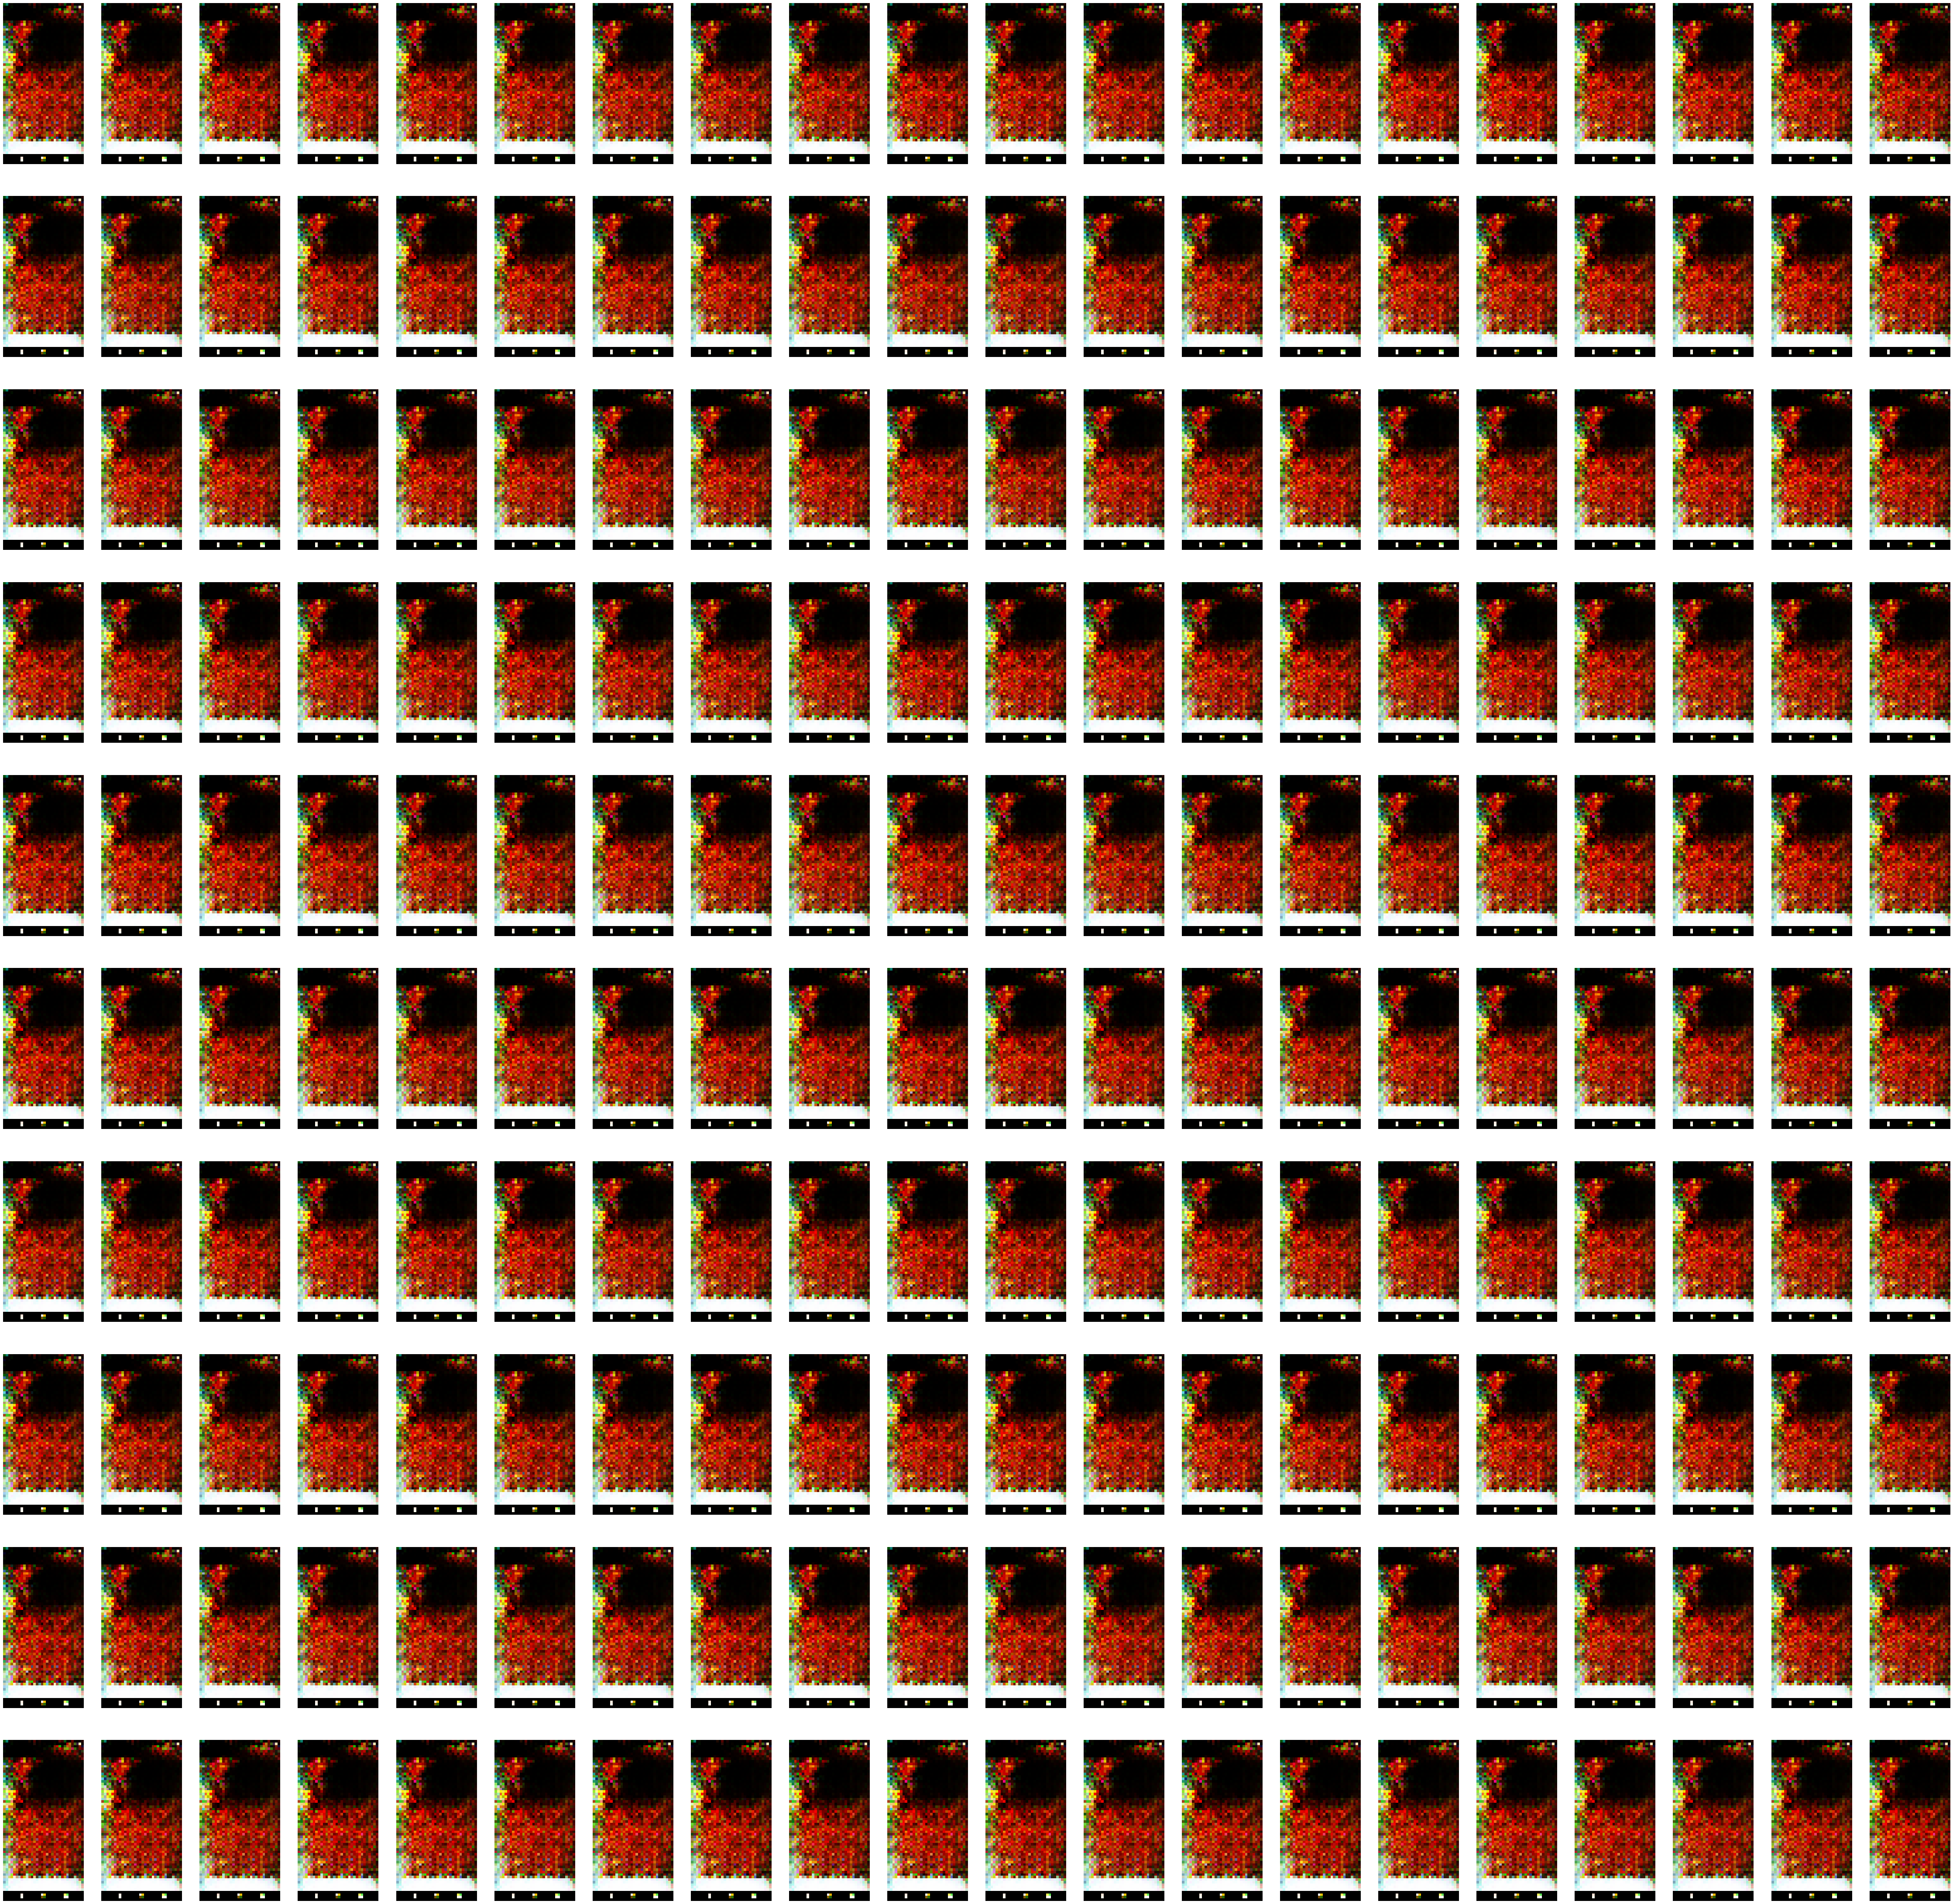

/content/drive/MyDrive/ML/checkpoints/mobilegan/model-v2.1


In [116]:
def test_model(checkpoint_dir):
  gan_model, g_model, d_model, g_opt, d_opt = create_gan_model_v2(LATENT_DIM)

  checkpoint = checkpoint_models(g_model, d_model, g_opt, d_opt)
  checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)
  checkpoint_manager.restore_or_initialize()  

  generate_and_show(g_model, LATENT_DIM, rows=10, cols=20, scale=4)

  # img_count = 4
  # imgs = generate_fake_samples(g_model, LATENT_DIM, img_count)
  # fig, ax = plt.subplots(ncols=img_count, figsize=(20, 10))
  # for i, img in enumerate(imgs):
  #   ax[i].imshow(np.squeeze(img))

test_model(current_checkpoints_dir)    
print(current_checkpoints_dir)